In [35]:
import pandas as pd
import numpy as np
import cv2
import itertools


from cycling_manager.preprocess import split, get_data, preprocess

from cycling_manager.sequences import get_sequences, get_sequence

from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Input, Conv2D, Flatten, MaxPooling2D, Masking, LayerNormalization, RepeatVector, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


from tensorflow.keras import Model



import tensorflow as tf

In [36]:
df = preprocess(get_data())

full df shape (603619, 25)
full df shape (603619, 25)
Score vertical meters - model: DecisionTreeRegressor() score: 0.9995713465041957
Score vertical meters - model: DecisionTreeRegressor() score: 0.999925327504786
Score vertical meters - model: KNeighborsClassifier() score: 0.995140551013853


In [37]:
train, test = split(df, start=2020, end=2022)

In [38]:
df.columns

Index(['name', 'year', 'type', 'date', 'result', 'gc', 'icon', 'race_ref',
       'race_name', 'race_detail', 'race_rank', 'distance', 'points',
       'Avg. speed winner:', 'Distance:', 'Parcours type:', 'ProfileScore:',
       'Vert. meters:', 'Startlist quality score:', 'Won how: ',
       'adjusted_points', 'Race category:', 'Points scale:', 'Arrival:',
       'Won how:', 'parcours_type_num', 'gt_binary', 'key', 'result_bin',
       'types_bin', 'icon_bin'],
      dtype='object')

In [39]:
train.year.unique()

array([2021, 2020])

In [41]:
y_dec_ls = []
tour_ls = []
season_ls = []
result_ls = []

for name, year, tour in train.values:
    y_decoder, tour_data, result, season_data = get_sequence(df, name, year, tour, img=True, binary=False, maxlen=30)
    y_dec_ls.append(y_decoder)
    tour_ls.append(tour_data)
    result_ls.append(result)
    season_ls.append(season_data)


 dropped nan for ('francesco-gavazzi', 2021, 'giro-d-italia')

 dropped nan for ('manuel-belletti', 2021, 'giro-d-italia')

 dropped nan for ('krists-neilands', 2021, 'giro-d-italia')

 dropped nan for ('jacopo-mosca', 2021, 'giro-d-italia')

 dropped nan for ('krists-neilands', 2020, 'tour-de-france')

 dropped nan for ('jacopo-mosca', 2020, 'giro-d-italia')

 dropped nan for ('marco-frapporti', 2020, 'giro-d-italia')


In [42]:
season_ls_img = []
to_drop_ls = []

for season in season_ls:
    base_path = '../raw_data/img_300/'
    season = [base_path+"_".join(race.split('/')[1:])+'.jpg' for race in season]
    
    img_ls = []
    
    for race in season:
        img = cv2.imread(race)
        try:
            img = tf.convert_to_tensor(img)
            img_ls.append(img)
        except:
            to_drop_ls.append('race/'+race.split('/')[-1].split('.')[0].replace('_', '/'))
        
    season_ls_img.append(np.array(img_ls))
    
season_ls_img = np.array(season_ls_img)
to_drop_ls = list(dict.fromkeys(to_drop_ls))
    

[ WARN:0@49076.905] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/danish-championships_2021_result.jpg'): can't open/read file: check file path/integrity
[ WARN:0@49077.055] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/nc-belgium_2020_result.jpg'): can't open/read file: check file path/integrity
[ WARN:0@49077.294] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/nc-switserland_2020_result.jpg'): can't open/read file: check file path/integrity
[ WARN:0@49077.420] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/nc-netherlands_2020_resu

In [ ]:
tour_ls_img = []

for season in tour_ls_img:
    base_path = '../raw_data/img_300/'
    season = [base_path+"_".join(race.split('/')[1:])+'.jpg' for race in season]
    
    img_ls = []
    
    for race in season:
        img = cv2.imread(race)
        try:
            img = tf.convert_to_tensor(img)
            img_ls.append(img)
        except:
            print(race)
        
    tour_ls_img.append(np.array(img_ls))
    
tour_ls_img = np.array(season_ls_img)

In [27]:
result_ls_2 = [list(itertools.chain(*x[~x.race_ref.isin(to_drop_ls)].drop(columns='race_ref').values)) for x in result_ls]

In [28]:
df_2 = df[~df.race_ref.isin(to_drop_ls)]

In [29]:
def get_sequences_img(season_ls, result_ls):
    new_season_ls = []
    new_result_ls = []
    
    for season, results in zip(season_ls, result_ls):
        if season.shape[0] == 0:
            pass
        else:
            print(season.shape)
            tensors_season = tf.convert_to_tensor(season, dtype=tf.float32)
            new_season_ls.append(tensors_season)
            
            tensors_y = tf.convert_to_tensor(results, dtype=tf.float32)
            new_result_ls.append(tensors_y)
        
    X_encoder_train = tf.ragged.stack(new_season_ls).to_tensor()
    y_encoder_train = tf.ragged.stack(new_result_ls).to_tensor()
    
    return X_encoder_train, y_encoder_train
        

In [30]:
def get_sequences_img(season_ls, result_ls):
    new_season_ls = []
    new_result_ls = []
    
    for season, results in zip(season_ls, result_ls):
        if season.shape[0] == 0:
            pass
        else:
            print(season.shape)
            tensors_season = tf.convert_to_tensor(season, dtype=tf.float32)
            new_season_ls.append(tensors_season)
            
            tensors_y = tf.convert_to_tensor(results, dtype=tf.float32)
            new_result_ls.append(tensors_y)
        
    X_encoder_train = tf.ragged.stack(new_season_ls).to_tensor()
    y_encoder_train = tf.ragged.stack(new_result_ls).to_tensor()
    
    return X_encoder_train, y_encoder_train

In [31]:
X_encoder_img_train, y_encoder_img_train = get_sequences_img(season_ls_img, result_ls_2)

X_encoder_img_train.shape, y_encoder_img_train.shape

(19, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(19, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(19, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(17, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(9, 150, 300, 3)
(4, 150, 300, 3)
(17, 150, 300, 3)
(15, 150, 300, 3)
(13, 150, 300, 3)
(18, 150, 300, 3)
(20, 150, 300, 3)
(11, 150, 300, 3)
(20, 150, 300, 3)
(20, 150, 300, 3)
(16, 150, 300, 3)
(20, 150, 300, 3)
(15, 150, 300, 3)
(20, 150, 300, 3)
(10, 150, 300, 3)
(20, 150, 300, 3)
(14, 150, 30

(TensorShape([942, 20, 150, 300, 3]), TensorShape([942, 20]))

In [32]:
model = Sequential()
# define CNN model
model.add(TimeDistributed(Rescaling(1./255, input_shape=(150,300,3))))

model.add(TimeDistributed(Conv2D(16, kernel_size=10, activation='relu')))
model.add(TimeDistributed(MaxPooling2D(3)))

model.add(TimeDistributed(Conv2D(32, kernel_size=6, activation="relu")))
model.add(TimeDistributed(MaxPooling2D(3)))

model.add(TimeDistributed(Flatten()))

model.add(TimeDistributed(Dense(100, activation='relu')))

model.add(TimeDistributed(Dense(30, activation='relu')))

# define LSTM model
model.add(LSTM(units=15, dropout=0.2, return_sequences=True, activation='tanh'))
model.add(Dense(units=1, activation='linear'))

In [17]:
def encoder_image(images):
    x = TimeDistributed(Rescaling(1./255, input_shape=(150,300,3)))(images)
    x = TimeDistributed(Conv2D(16, kernel_size=10, activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D(3))(x)
    x = TimeDistributed(Conv2D(32, kernel_size=10, activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D(3))(x)
    x = TimeDistributed(Conv2D(16, kernel_size=8, activation='relu'))(x)
    x = TimeDistributed(MaxPooling2D(3))(x)
    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    x = TimeDistributed(Dense(30, activation='relu'))(x)
    
    return x
    

In [14]:
def encoder(encoder_features, image_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    
    y = Concatenate(axis=-1)([y, image_features])
    
    #each LSTM unit returning a sequence of 6 outputs, one for each time step in the input data
    y = LSTM(units=15, dropout=0.2, return_sequences=True, activation='tanh')(y)
    y = LayerNormalization()(y)
    y = LSTM(units=30, dropout=0.2, return_sequences=True, activation='tanh')(y)
    y = LayerNormalization()(y)
    #output one time step from the sequence for each time step in the input but process 5 outputs of the input sequence at a time
    #y = TimeDistributed(Dense(units=5, activation='tanh'))(y)
    y = LSTM(units=14, dropout=0.2, return_sequences=False, activation='tanh')(y)
    y = RepeatVector(21)(y)
    return y

In [26]:
def decoder(decoder_features, encoder_outputs, image_features):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs, image_features])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    x = TimeDistributed(Dense(units=32, activation='relu'))(x)
    x = TimeDistributed(Dense(units=16, activation='relu'))(x)
    x = TimeDistributed(Dense(units=6, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1, activation='linear'))(x)
    return y

def combine_model(X_encoder, X_decoder, img_encoder, img_decoder):
    
    # define input shapes
    encoder_features = Input(shape=X_encoder.shape[1:])
    decoder_features = Input(shape=X_decoder.shape[1:])
    encoder_img_features = Input(shape=img_encoder.shape[1:])
    decoder_img_features = Input(shape=img_decoder.shape[1:])
    
    #get cnn output for encoder/decoder
    encoder_img_features = encoder_image(encoder_img_features)
    decoder_img_features = encoder_image(decoder_img_features)
    
    #set encoder
    encoder_outputs = encoder(encoder_features, encoder_img_features)
    
    #set dedocer
    decoder_outputs = decoder(decoder_features, encoder_outputs, decoder_img_features)
    
    #set model
    model = Model([encoder_features, encoder_img_features, decoder_features, decoder_img_features], decoder_outputs)
    
    #print(Fore.YELLOW + f"\nCombined model..." + Style.RESET_ALL)
    
    return model

def compile_model(model):
    
    initial_learning_rate = 0.01

    lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.5)

    adam = Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=adam, loss='mean_absolute_error', metrics='mean_absolute_error')
    
    #print(Fore.YELLOW + f"\Compile model..." + Style.RESET_ALL)

    return model

In [33]:
initial_learning_rate = 0.01

lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.5)

adam = Adam(learning_rate=lr_schedule)

    
model.compile(optimizer=adam, loss='mean_absolute_error', metrics='mean_absolute_error')

In [34]:
batch_size=8
patience=3
validation_split=0.3

es = EarlyStopping(monitor="val_loss",
                       patience=patience,
                       restore_best_weights=True,
                       verbose=0)

history = model.fit(X_encoder_img_train, y_encoder_img_train,
                        validation_split=validation_split,
                        epochs=1000,
                        batch_size=batch_size,
                        callbacks=[es],
                        verbose=1)

Epoch 1/1000
83/83 [==============================] - 363s 4s/step - loss: 55.8377 - mean_absolute_error: 55.8377 - val_loss: 53.0101 - val_mean_absolute_error: 53.0101
Epoch 2/1000
83/83 [==============================] - 358s 4s/step - loss: 53.1093 - mean_absolute_error: 53.1093 - val_loss: 51.3310 - val_mean_absolute_error: 51.3310
Epoch 3/1000
83/83 [==============================] - 359s 4s/step - loss: 51.8576 - mean_absolute_error: 51.8576 - val_loss: 50.4332 - val_mean_absolute_error: 50.4332
Epoch 4/1000
71/83 [========================>.....] - ETA: 51s - loss: 50.5544 - mean_absolute_error: 50.5544

KeyboardInterrupt: 

In [16]:
history

In [24]:
model.save('../models/cnn/40/')

INFO:tensorflow:Assets written to: ../models/cnn/40/assets


INFO:tensorflow:Assets written to: ../models/cnn/40/assets


In [21]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

In [22]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

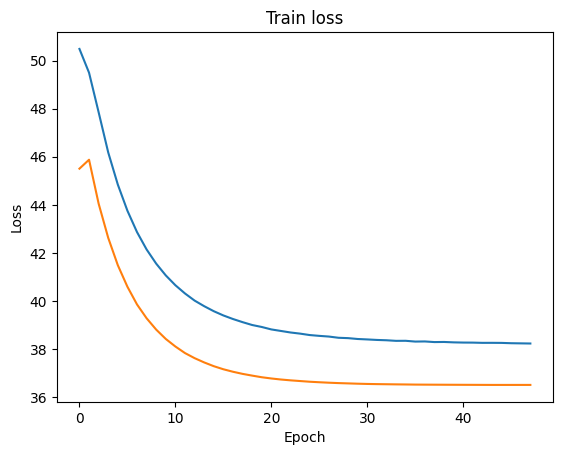

In [23]:
plot_history(history)